## Udacity Machine Learning Nanodegree Capstone Project
##### Ratna Bearavolu
##### June 19,2018

### Introduction

Python notebook for solving Avito-Prediction challenge posted on Kaggle.com. Please refer to the Capstone Proposal document for the solution architecture. 

About the environment: Initial work (Exploratory Data analysis) was done on kaggle docker. However, due to memory constraints, moved the notebook to an AWS instance (p2.xlarge instance running linux platform with 60GB of RAM and 2TB of hard drive). The python kernel used is the same kernel that Udacity had suggested for doing the Dog-Breed Classifier CNN project. Following is the additional package I installed for this project
* Python XGBoost package (http://xgboost.readthedocs.io/en/latest/python/python_intro.html)

The data used for this project can be found at https://www.kaggle.com/c/avito-demand-prediction/data. Kaggle provides an api to download data. From the aws instance, used the kaggle api to get the following data.
* train.csv.zip, test.csv.zip, train_jpg.zip, test_jpg.zip



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
import math
import os
print(os.listdir(".kaggle/competitions/avito-demand-prediction"))
from IPython.display import Image


#using boolean variables to control/run the notebook piecemeal.

flg_mdl_1 = False
flg_mdl_2 = False
flg_mdl_1_xgb_gridsearch = False
flg_cmb_two_mdls = False
flg_process_img = False
flg_eval_cnn_mdl = False
flg_alt_unified_desc_tabular_data = False
flg_cmb_three_mdls = False


['sample_submission.csv', 'train.csv.zip', 'images', 'test.csv', 'test.csv.zip', 'test_jpg', 'train.csv', 'tst_images']


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read in train and test data 
df_train = pd.read_csv(".kaggle/competitions/avito-demand-prediction/train.csv")
df_test = pd.read_csv(".kaggle/competitions/avito-demand-prediction/test.csv")

In [3]:
print ("Train_data: Num rows : {} Num columns : {}".format(df_train.shape[0],df_train.shape[1]))
print ("Test_data: Num rows : {} Num columns : {}".format(df_test.shape[0],df_test.shape[1]))
df_train.head(5)

#item_id is the unique identifier of each row
#df.item_id.nunique()



Train_data: Num rows : 1503424 Num columns : 18
Test_data: Num rows : 508438 Num columns : 17


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [4]:
df_train.describe()

,price,item_seq_number,image_top_1,deal_probability
count,1.418062e+06,1.503424e+06,1.390836e+06,1.503424e+06
mean,3.167081e+05,7.436740e+02,1.241932e+03,1.391306e-01
std,6.689154e+07,5.572522e+03,9.704641e+02,2.600785e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+02,9.000000e+00,4.250000e+02,0.000000e+00
50%,1.300000e+03,2.900000e+01,1.057000e+03,0.000000e+00
75%,7.000000e+03,8.800000e+01,2.217000e+03,1.508700e-01
max,7.950101e+10,2.044290e+05,3.066000e+03,1.000000e+00


In [5]:
df_test.describe()

,price,item_seq_number,image_top_1
count,4.778530e+05,508438.000000,465829.000000
mean,2.798189e+05,825.132150,1297.959228
std,5.364218e+06,5646.868618,961.065300
min,0.000000e+00,1.000000,0.000000
25%,5.000000e+02,8.000000,467.000000
50%,1.500000e+03,30.000000,1132.000000
75%,8.600000e+03,94.000000,2218.000000
max,3.000060e+09,205064.000000,3066.000000


#### Functions to split the data into three different dataframes. 
* df_md1 - mostly contains categorical data
* df_md2 - contains description column
* df_md3 - contains image info column

In [6]:
def split_train_data(df,sample_size):
    df_sampled = df.sample(sample_size)
    df_md1 = df_sampled.drop(['description','image'],axis=1).set_index('item_id')
    df_md2 = (df_sampled[['item_id','description','deal_probability']]).set_index('item_id')
    df_md3 = (df_sampled[['item_id','image','deal_probability']]).set_index('item_id')
    return df_md1, df_md2,df_md3

def split_test_data(df):
    df_md1 = df.drop(['description','image'],axis=1).set_index('item_id')
    df_md2 = (df[['item_id','description']]).set_index('item_id')
    df_md3 = (df[['item_id','image']]).set_index('item_id')
    return df_md1, df_md2,df_md3



df_md1,df_md2,df_md3 = split_train_data(df_train,df_train.shape[0])

df_tst_md1,df_tst_md2,df_tst_md3 = split_test_data(df_test)

### Exploratory Data Analyis and some Feature Engineering 

The next few cells contain various data views to better understand the data.


#### Using the dictionaries from Yandex/SRK/SBAN Kernel (from Kaggle), to map the russian columns to english to help me look at the data

In [7]:
parent_category_name_map = {"Личные вещи" : "Personal belongings",
                            "Для дома и дачи" : "For the home and garden",
                            "Бытовая электроника" : "Consumer electronics",
                            "Недвижимость" : "Real estate",
                            "Хобби и отдых" : "Hobbies & leisure",
                            "Транспорт" : "Transport",
                            "Услуги" : "Services",
                            "Животные" : "Animals",
                            "Для бизнеса" : "For business"}

region_map = {"Свердловская область" : "Sverdlovsk oblast",
            "Самарская область" : "Samara oblast",
            "Ростовская область" : "Rostov oblast",
            "Татарстан" : "Tatarstan",
            "Волгоградская область" : "Volgograd oblast",
            "Нижегородская область" : "Nizhny Novgorod oblast",
            "Пермский край" : "Perm Krai",
            "Оренбургская область" : "Orenburg oblast",
            "Ханты-Мансийский АО" : "Khanty-Mansi Autonomous Okrug",
            "Тюменская область" : "Tyumen oblast",
            "Башкортостан" : "Bashkortostan",
            "Краснодарский край" : "Krasnodar Krai",
            "Новосибирская область" : "Novosibirsk oblast",
            "Омская область" : "Omsk oblast",
            "Белгородская область" : "Belgorod oblast",
            "Челябинская область" : "Chelyabinsk oblast",
            "Воронежская область" : "Voronezh oblast",
            "Кемеровская область" : "Kemerovo oblast",
            "Саратовская область" : "Saratov oblast",
            "Владимирская область" : "Vladimir oblast",
            "Калининградская область" : "Kaliningrad oblast",
            "Красноярский край" : "Krasnoyarsk Krai",
            "Ярославская область" : "Yaroslavl oblast",
            "Удмуртия" : "Udmurtia",
            "Алтайский край" : "Altai Krai",
            "Иркутская область" : "Irkutsk oblast",
            "Ставропольский край" : "Stavropol Krai",
            "Тульская область" : "Tula oblast"}


category_map = {"Одежда, обувь, аксессуары":"Clothing, shoes, accessories",
"Детская одежда и обувь":"Children's clothing and shoes",
"Товары для детей и игрушки":"Children's products and toys",
"Квартиры":"Apartments",
"Телефоны":"Phones",
"Мебель и интерьер":"Furniture and interior",
"Предложение услуг":"Offer services",
"Автомобили":"Cars",
"Ремонт и строительство":"Repair and construction",
"Бытовая техника":"Appliances",
"Товары для компьютера":"Products for computer",
"Дома, дачи, коттеджи":"Houses, villas, cottages",
"Красота и здоровье":"Health and beauty",
"Аудио и видео":"Audio and video",
"Спорт и отдых":"Sports and recreation",
"Коллекционирование":"Collecting",
"Оборудование для бизнеса":"Equipment for business",
"Земельные участки":"Land",
"Часы и украшения":"Watches and jewelry",
"Книги и журналы":"Books and magazines",
"Собаки":"Dogs",
"Игры, приставки и программы":"Games, consoles and software",
"Другие животные":"Other animals",
"Велосипеды":"Bikes",
"Ноутбуки":"Laptops",
"Кошки":"Cats",
"Грузовики и спецтехника":"Trucks and buses",
"Посуда и товары для кухни":"Tableware and goods for kitchen",
"Растения":"Plants",
"Планшеты и электронные книги":"Tablets and e-books",
"Товары для животных":"Pet products",
"Комнаты":"Room",
"Фототехника":"Photo",
"Коммерческая недвижимость":"Commercial property",
"Гаражи и машиноместа":"Garages and Parking spaces",
"Музыкальные инструменты":"Musical instruments",
"Оргтехника и расходники":"Office equipment and consumables",
"Птицы":"Birds",
"Продукты питания":"Food",
"Мотоциклы и мототехника":"Motorcycles and bikes",
"Настольные компьютеры":"Desktop computers",
"Аквариум":"Aquarium",
"Охота и рыбалка":"Hunting and fishing",
"Билеты и путешествия":"Tickets and travel",
"Водный транспорт":"Water transport",
"Готовый бизнес":"Ready business",
"Недвижимость за рубежом":"Property abroad"}


In [8]:
#adding the english translation columns

df_md1['category_name_en'] = df_md1['category_name'].apply(lambda x : category_map[x])
df_md1['parent_category_name_en'] = df_md1['parent_category_name'].apply(lambda x: parent_category_name_map[x])
df_md1['region_en'] = df_md1['region'].apply(lambda x: region_map[x])

#test data
df_tst_md1['category_name_en'] = df_tst_md1['category_name'].apply(lambda x : category_map[x])
df_tst_md1['parent_category_name_en'] = df_tst_md1['parent_category_name'].apply(lambda x: parent_category_name_map[x])
df_tst_md1['region_en'] = df_tst_md1['region'].apply(lambda x: region_map[x])

In [9]:
print ("Number of unique parent_categories: {}".format(df_md1['parent_category_name'].nunique()))
print ("Number of unique categories: {}".format(df_md1['category_name'].nunique()))

print ("Test: Number of unique parent_categories: {}".format(df_tst_md1['parent_category_name'].nunique()))
print ("Test: Number of unique categories: {}".format(df_tst_md1['category_name'].nunique()))

Number of unique parent_categories: 9
Number of unique categories: 47
Test: Number of unique parent_categories: 9
Test: Number of unique categories: 47


Ad count by category: 
 Clothing, shoes, accessories        282753
Children's clothing and shoes       270359
Children's products and toys         99747
Apartments                           83670
Phones                               65944
Furniture and interior               65035
Offer services                       64385
Cars                                 62494
Repair and construction              56201
Appliances                           33705
Products for computer                29565
Houses, villas, cottages             29244
Health and beauty                    29198
Audio and video                      27036
Sports and recreation                24881
Equipment for business               16047
Land                                 16038
Watches and jewelry                  15566
Books and magazines                  11819
Dogs                                 11612
Games, consoles and software         11167
Other animals                        11040
Bikes                         

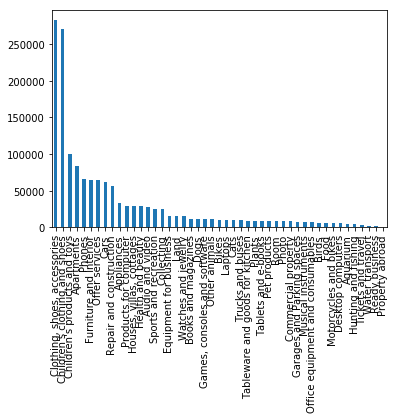

In [10]:
#group the ads by category to see the distribution 
print('Ad count by category: \n {}'.format(df_md1['category_name_en'].value_counts()))

df_md1['category_name_en'].value_counts().plot.bar()
plt.show()

#From the graph, Clothing, shoes, accessories and Children clothing and shoes are the top two categories of ads


Ad count by parent category: 
 Personal belongings        697623
For the home and garden    178823
Consumer electronics       173008
Real estate                153190
Hobbies & leisure           86011
Transport                   79839
Services                    64385
Animals                     52470
For business                18075
Name: parent_category_name_en, dtype: int64


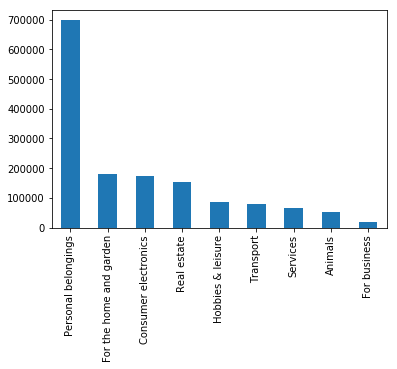

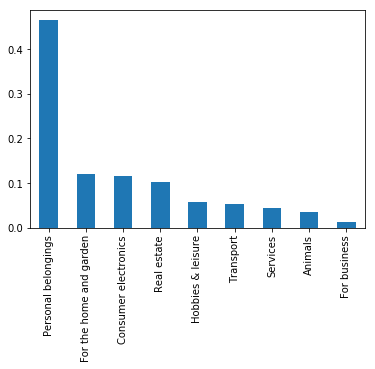

In [11]:
#plot ad distribution by parent category
print('Ad count by parent category: \n {}'.format(df_md1['parent_category_name_en'].value_counts()))

df_md1['parent_category_name_en'].value_counts().plot.bar()
plt.show()

#personal belongings has the highest ads

#normalized view of the parent_category_distribution of the trianing data
df_md1['parent_category_name_en'].value_counts(normalize=True).plot.bar()
plt.show()

Test: Ad count by parent category: 
 Personal belongings        0.425965
For the home and garden    0.127666
Consumer electronics       0.114630
Real estate                0.112869
Hobbies & leisure          0.061504
Transport                  0.058912
Services                   0.046454
Animals                    0.039289
For business               0.012711
Name: parent_category_name_en, dtype: float64


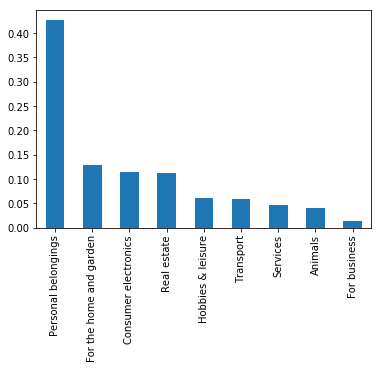

In [12]:
#plot ad distribution by parent category on test data. Want to see if the distribution is similar to train data
print('Test: Ad count by parent category: \n {}'.format(df_tst_md1['parent_category_name_en'].value_counts(normalize=True)))

df_tst_md1['parent_category_name_en'].value_counts(normalize=True).plot.bar()
plt.show()

#personal belongings has the highest ads

In [13]:
#trying to get an insight into which parent category had the highest average deal_probability
df_md1.groupby(['parent_category_name_en']).describe() #['price','deal_probability'].mean()

deal_probability                                    \
                                   count      mean       std  min      25%   
parent_category_name_en                                                      
Animals                          52470.0  0.235957  0.286774  0.0  0.00000   
Consumer electronics            173008.0  0.175421  0.279319  0.0  0.00000   
For business                     18075.0  0.111026  0.216779  0.0  0.00000   
For the home and garden         178823.0  0.179633  0.307092  0.0  0.00000   
Hobbies & leisure                86011.0  0.123703  0.260213  0.0  0.00000   
Personal belongings             697623.0  0.075876  0.209260  0.0  0.00000   
Real estate                     153190.0  0.142051  0.192078  0.0  0.00000   
Services                         64385.0  0.403123  0.346907  0.0  0.14286   
Transport                        79839.0  0.263336  0.292592  0.0  0.00000   

                                                   image_top_1               \
                             50%      75%      max       count         mean   
parent_category_name_en                                                       
Animals                  0.10994  0.38305  0.78503     44295.0  2032.509155   
Consumer electronics     0.00000  0.24873  0.76786    164906.0  2829.095000   
For business             0.00000  0.11742  0.78912     16822.0  1610.888301   
For the home and garden  0.00000  0.22296  0.86521    166559.0  1554.712150   
Hobbies & leisure        0.00000  0.09587  0.82668     82974.0  2130.380059   
Personal belongings      0.00000  0.00000  0.80323    691301.0   480.199185   
Real estate              0.07438  0.18992  1.00000    104067.0  1857.339993   
Services                 0.33333  0.60000  1.00000     45185.0  1646.964501   
Transport                0.12974  0.48305  0.74043     74727.0  1448.944558   

                             ...      item_seq_number               price  \
                             ...                  75%       max     count   
parent_category_name_en      ...                                            
Animals                      ...                 71.0    7547.0   38833.0   
Consumer electronics         ...                102.0   72851.0  168845.0   
For business                 ...                185.0   70490.0   15569.0   
For the home and garden      ...                 90.0   72711.0  168689.0   
Hobbies & leisure            ...                121.0   71420.0   80805.0   
Personal belongings          ...                 84.0   71596.0  686389.0   
Real estate                  ...                396.0  204429.0  139433.0   
Services                     ...                 30.0   56828.0   42151.0   
Transport                    ...                 45.0   34078.0   77348.0   

                                                                               \
                                 mean           std  min       25%        50%   
parent_category_name_en                                                         
Animals                  3.592779e+04  1.556356e+06  0.0     200.0     1000.0   
Consumer electronics     1.857283e+04  1.880481e+06  0.0     850.0     2500.0   
For business             6.830458e+05  2.105834e+07  0.0    4900.0    20000.0   
For the home and garden  2.023698e+04  2.215031e+06  0.0     500.0     2000.0   
Hobbies & leisure        1.892546e+04  1.759850e+06  0.0     450.0     1500.0   
Personal belongings      8.211906e+03  1.189118e+06  0.0     350.0      700.0   
Real estate              2.810947e+06  2.131428e+08  0.0  250000.0  1300000.0   
Services                 1.321863e+04  8.581824e+05  0.0     180.0      500.0   
Transport                3.991143e+05  8.286961e+05  0.0   85000.0   220000.0   

                                                  
                               75%           max  
parent_category_name_en                           
Animals                     5000.0  2.000150e+08  
Consumer electronics        7990.0  

In [14]:
#df.groupby(['parent_category_name_en','category_name_en']).agg('mean')
#Break down of ad count by parent_category and category
df_md1.groupby(['parent_category_name_en','category_name_en']).agg('count')

user_id  region  \
parent_category_name_en category_name_en                                    
Animals                 Aquarium                             4840    4840   
                        Birds                                6447    6447   
                        Cats                                 9951    9951   
                        Dogs                                11612   11612   
                        Other animals                       11040   11040   
                        Pet products                         8580    8580   
Consumer electronics    Audio and video                     27036   27036   
                        Desktop computers                    5450    5450   
                        Games, consoles and software        11167   11167   
                        Laptops                             10297   10297   
                        Office equipment and consumables     6580    6580   
                        Phones                              65944   65944   
                        Photo                                8345    8345   
                        Products for computer               29565   29565   
                        Tablets and e-books                  8624    8624   
For business            Equipment for business              16047   16047   
                        Ready business                       2028    2028   
For the home and garden Appliances                          33705   33705   
                        Food                                 5781    5781   
                        Furniture and interior              65035   65035   
                        Plants                               9025    9025   
                        Repair and construction             56201   56201   
                        Tableware and goods for kitchen      9076    9076   
Hobbies & leisure       Bikes                               10638   10638   
                        Books and magazines                 11819   11819   
                        Collecting                          24346   24346   
                        Hunting and fishing                  4524    4524   
                        Musical instruments                  6695    6695   
                        Sports and recreation               24881   24881   
                        Tickets and travel                   3108    3108   
Personal belongings     Children's clothing and shoes      270359  270359   
                        Children's products and toys        99747   99747   
                        Clothing, shoes, accessories       282753  282753   
                        Health and beauty                   29198   29198   
                        Watches and jewelry                 15566   15566   
Real estate             Apartments                          83670   83670   
                        Commercial property                  8305    8305   
                        Garages and Parking spaces           7304    7304   
                        Houses, villas, cottages            29244   29244   
                        Land                                16038   16038   
                        Property abroad                       117     117   
                        Room                                 8512    8512   
Services                Offer services                      64385   64385   
Transport               Cars                                62494   62494   
                        Motorcycles and bikes                5771    5771   
                        Trucks and buses                     9394    9394   
                        Water transport                      2180    2180   

                                                            city  \
parent_category_name_en category_name_en                           
Animals                 Aquarium                            4840   
                        Birds                               6447   
            

In [15]:
#look at the mean price and deal_probability to get a sense of the scale of price and range of probabilities. 
#Initial takeaway - No one parent_category/category seem to be doing much better or worse. 
#df.groupby(['parent_category_name_en','category_name_en']).agg('mean')
df_md1.groupby(['parent_category_name_en','category_name_en'])['price','deal_probability'].mean()

price  \
parent_category_name_en category_name_en                                 
Animals                 Aquarium                          3.149496e+03   
                        Birds                             3.500596e+04   
                        Cats                              1.666761e+04   
                        Dogs                              1.030408e+04   
                        Other animals                     1.146810e+05   
                        Pet products                      6.029656e+03   
Consumer electronics    Audio and video                   7.518729e+03   
                        Desktop computers                 1.297918e+04   
                        Games, consoles and software      7.701659e+03   
                        Laptops                           1.318337e+04   
                        Office equipment and consumables  5.388955e+03   
                        Phones                            3.008696e+04   
                        Photo                             9.029348e+03   
                        Products for computer             1.943345e+04   
                        Tablets and e-books               5.086037e+03   
For business            Equipment for business            3.937724e+05   
                        Ready business                    2.906996e+06   
For the home and garden Appliances                        7.944267e+03   
                        Food                              1.020555e+03   
                        Furniture and interior            3.220149e+04   
                        Plants                            2.259273e+03   
                        Repair and construction           2.123771e+04   
                        Tableware and goods for kitchen   2.470037e+03   
Hobbies & leisure       Bikes                             8.177324e+03   
                        Books and magazines               1.093600e+04   
                        Collecting                        4.251077e+04   
                        Hunting and fishing               4.617569e+03   
                        Musical instruments               1.254745e+04   
                        Sports and recreation             1.037242e+04   
                        Tickets and travel                2.202707e+04   
Personal belongings     Children's clothing and shoes     9.787546e+03   
                        Children's products and toys      4.129398e+03   
                        Clothing, shoes, accessories      8.243247e+03   
                        Health and beauty                 4.512370e+03   
                        Watches and jewelry               1.335892e+04   
Real estate             Apartments                        2.003441e+06   
                        Commercial property               6.735045e+06   
                        Garages and Parking spaces        2.651850e+05   
                        Houses, villas, cottages          2.651154e+06   
                        Land                              8.210750e+06   
                        Property abroad                   1.154915e+07   
                        Room                              4.029475e+05   
Services                Offer services                    1.321863e+04   
Transport               Cars                              3.779836e+05   
                        Motorcycles and bikes             1.287009e+05   
                        Trucks and buses                  7.629971e+05   
                        Water transport                   2.665777e+05   

                                                          deal_probability  
parent_category_name_en category_name_en                                    
Animals                 Aquarium                                  0.183616  
                        Birds                                     0.238340  
                        Cats                                      0.297259  
                        Dogs                         

### Feature Engineering - activation_date
Breaking up the 'activation_date" into four individual columns. Plot the data to see the time ranges of the training data. Based on the below plot, it shows that all the training data was from last two weeks of the month.

In [16]:
#Break up activation_date into month, year and day of the week. Check if there are any patterns between the deal_prob and the day an ad
#was activated

from datetime import datetime

def prep_activation_date(df):
    df['month'] = df.activation_date.apply(lambda x: int(x[5:7]))

    df['day'] = df.activation_date.apply(lambda x: int(x[8:10]))

    df['year'] = df.activation_date.apply(lambda x: int(x[0:4]))

    df['weekday'] = df.activation_date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date().weekday()) 

prep_activation_date(df_md1)
prep_activation_date(df_tst_md1)


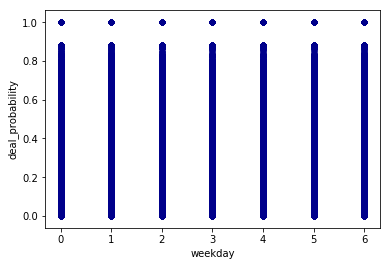

In [17]:
#Look at deal_probability by day of the week

import matplotlib.pyplot as plt
#df[df.price <= 800].plot.scatter(x='weekday',
df_md1.plot.scatter(x='weekday',y='deal_probability',c='DarkBlue')
plt.show()

#From the graph, there doesn't seem to be any apparent trends 
#E.g., ads activated on Saturday,Sunday had higher deal_probabobility


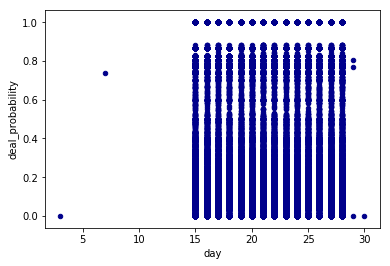

In [18]:
#again, based on the sample scatter plot, there are no apparent trends on any specific day of the activation date
df_md1.sample(100000).plot.scatter(x='day',
                       y='deal_probability',
               c='DarkBlue')

plt.show()

### Preparing data - The next few cells address the missing data, scaling of data (price column) for model_1. 


In [19]:
def cols_with_missing_data(df):
    cols_with_missing_data = []

    for col in df.columns:
        #print("processing col: {}".format(col))
        #missing_data = df[df[col]== -1][col].count()
        missing_data = df[col].isnull().sum()
        if missing_data > 0:
            percent_missing = (missing_data/(df.shape[0]))*100
            cols_with_missing_data.append(col)
            print ("{} has {} of data missing".format(col,percent_missing))


#for each columnar data, compute the percent of missing data
print ('Missing Train data *******************************')  
cols_with_missing_data(df_md1)

print ('Missing Test data *******************************')  
cols_with_missing_data(df_tst_md1)

Missing Train data *******************************
param_1 has 4.09571750883317 of data missing
param_2 has 43.536753437486695 of data missing
param_3 has 57.3733690562343 of data missing
price has 5.677839385296497 of data missing
image_top_1 has 7.48877229577285 of data missing
Missing Test data *******************************
param_1 has 4.505957461873424 of data missing
param_2 has 45.87166970210724 of data missing
param_3 has 60.24943060904181 of data missing
price has 6.015482713723207 of data missing
image_top_1 has 8.380372828152105 of data missing


In [20]:
#handle missing data. With more than 50% of missing data in both training and testing data, decided to drop the param_3
df_md1.drop(['param_3'],axis=1,inplace=True)
df_md1.param_2.fillna('unknown',inplace=True)
df_md1.param_1.fillna('unknown',inplace=True)
df_md1.price.fillna(0.0,inplace=True)

#clean up the test data as well
df_tst_md1.drop(['param_3'],axis=1,inplace=True)
df_tst_md1.param_2.fillna('unknown',inplace=True)
df_tst_md1.param_1.fillna('unknown',inplace=True)
df_tst_md1.price.fillna(0.0,inplace=True)




In [21]:
#scale price column using log
df_md1['price'] = df_md1.price.apply(lambda x: np.log(x + 1))
df_tst_md1['price'] = df_tst_md1.price.apply(lambda x: np.log(x + 1))


In [22]:
#fill in image_top with a place holder 9999.0
df_md1.image_top_1.fillna(9999.0,inplace=True)
df_tst_md1.image_top_1.fillna(9999.0,inplace=True)


In [23]:
 #print the unique values of the categorical columns
cat_cols = ['region','city','parent_category_name','category_name','param_1','param_2','image_top_1','user_type','weekday']

for col in cat_cols:
    print(col,':{}'.format(df_md1[col].nunique()))


region :28
city :1733
parent_category_name :9
category_name :47
param_1 :372
param_2 :272
image_top_1 :3063
user_type :3
weekday :7


In [24]:
#check if there are categorical values that appear in train set and not in test and vice versa
#empty list indicates that they are overlapping
for col in cat_cols:
 print ('*************************************************')
 print('Test data', col,'is subset of Train data: ', set(df_tst_md1[col]).issubset(set(df_md1[col])))
 print('Test data', col, 'has additional : ',set(df_tst_md1[col]).difference(set(df_md1[col])))





*************************************************
Test data region is subset of Train data:  True
Test data region has additional :  set()
*************************************************
Test data city is subset of Train data:  False
Test data city has additional :  {'Расшеватская', 'Слобода', 'Тура', 'Новая Чигла', 'Сигаево', 'Днепровская', 'Менделеево', 'Индустриальный', 'Мирской', 'Кардаилово', 'Улукулево', 'Кубанский', 'Елизаветинское', 'Прочноокопская', 'Пычас', 'Азанка', 'Коелга', 'Юшала', 'Кара-Тюбе'}
*************************************************
Test data parent_category_name is subset of Train data:  True
Test data parent_category_name has additional :  set()
*************************************************
Test data category_name is subset of Train data:  True
Test data category_name has additional :  set()
*************************************************
Test data param_1 is subset of Train data:  True
Test data param_1 has additional :  set()
***********************

In [25]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#encode user_type and weekday using OneHotEncoder
colsToEncode = ['user_type','weekday']
df_md1 = pd.get_dummies(df_md1,columns=colsToEncode)
df_tst_md1 = pd.get_dummies(df_tst_md1,columns=colsToEncode)



### Handling high cardinal categorical values

Apart from price, all the columns are categorical. As seen from the output above, most of the columns have high cardinality. One-hot encoding is not the appropriate technique, as this will increase the dimensionality of the data rapidly. During my exploration process, my initial approach was to simply label-encode the various categoies. This does address the dimensionality increase issue, but inherently imposes an ordinal structure and depending on the model I choose, may lead to incorrect results. I searched for other techniques of handling high cardinal categorical columns and found this paper 
https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
I have decided to use this technique to convert the categorical columns. 


In [26]:
#convert the following categorical columns into numerical columns
#Hanging on to this cell, for future experiments

#cols_to_convert = ['region','city','parent_category_name_en','category_name_en','param_1','param_2','image_top_1']

#for col in cols_to_convert:
 #   df_md1[col+'_numeric'] = df_md1[col].astype('category').cat.codes
    
#for col in cols_to_convert:
 #   df_md1[col+'_numeric'] = df_md1[col].astype('category').cat.codes



In [27]:
#encode high cardinal categorical columns 
#https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
#Base Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features. Added additional logic to 
#handle categorical values that are in test data and not in train data. 

def encode_cat_column(train_cat_col,test_cat_col,target_col,min_sample_size,slope_trans_rate):
   
    #add missing categorical values from test_cat_col to train_cat_col
    m_cat = list(set(test_cat_col).difference(set(train_cat_col)))
    if(len(m_cat) > 0):
        train_cat_col = train_cat_col.append(pd.Series(m_cat)).rename(train_cat_col.name)
        target_col = target_col.append(pd.Series([0.0 for x in range(len(m_cat))])).rename(target_col.name)
       
    temp = pd.concat([train_cat_col, target_col], axis=1)
    # Compute mean and count by individual categorical value present in the categorical column 
    averages = temp.groupby(by=train_cat_col.name)[target_col.name].agg(["mean", "count"])

    # Compute lamdaFunction
    lambdaFunc = 1 / (1 + np.exp(-(averages["count"] - min_sample_size) / slope_trans_rate))

    # get prior prob of the target_column
    prior_prb = target_col.mean()
    #compute the blended probability estimate for the individual categorial values
    averages[target_col.name] = lambdaFunc*averages["mean"] + (1 - lambdaFunc)*prior_prb 
    # create a lookup dictionaly - key = category, value = blended probability estimate
    lkup = averages[target_col.name].to_dict()
    return train_cat_col.apply(lambda x : lkup.get(x)),test_cat_col.apply(lambda x : lkup.get(x))
   
cols_to_encode = ['region','city','parent_category_name','category_name','param_1','param_2','image_top_1']

for col in cols_to_encode:
    df_md1[col+'_encd'],df_tst_md1[col+'_encd'] = encode_cat_column(df_md1[col],df_tst_md1[col],df_md1['deal_probability'],500,13)



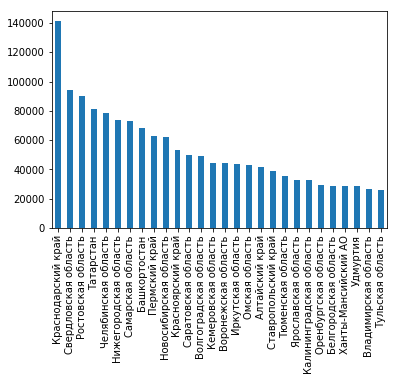

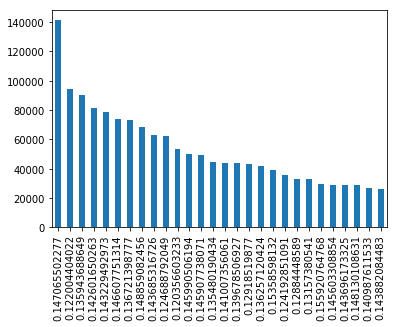

In [28]:
#Visual inspection - plot counts by region and region_encd
#they should be indentical, except the x labels

df_md1['region'].value_counts().plot.bar()
plt.show()

df_md1['region_encd'].value_counts().plot.bar()
plt.show()





In [29]:


# plt.scatter(df_tst_md1["region"], df_tst_md1["region_encd"])
# plt.xlabel("region cat values")
# plt.ylabel("Encoded value")
# plt.show()



In [30]:
#Look at deal_probability by day of the week


#df[df.price <= 800].plot.scatter(x='weekday',
#df_md1.plot.scatter(x='category_name_en_numeric',y='deal_probability',
             #  c='DarkBlue')

#plt.show()

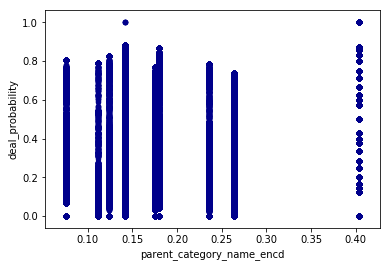

In [31]:
#Look at deal_probability by parent_category

import matplotlib.pyplot as plt
#df[df.price <= 800].plot.scatter(x='weekday',
df_md1.plot.scatter(x='parent_category_name_encd',y='deal_probability',
               c='DarkBlue')

plt.show()

In [32]:
#df.groupby('parent_category_name_en')['category_name_en'].value_counts()
df_md1.groupby('category_name_en')['deal_probability'].describe()

,count,mean,std,min,25%,50%,75%,max
category_name_en,,,,,,,,
Apartments,83670.0,0.158154,0.206681,0.0,0.00000,0.07612,0.213010,1.00000
Appliances,33705.0,0.252776,0.357260,0.0,0.00000,0.00000,0.440200,0.86521
Aquarium,4840.0,0.183616,0.282600,0.0,0.00000,0.00000,0.280940,0.78503
Audio and video,27036.0,0.171572,0.282541,0.0,0.00000,0.00000,0.234980,0.76786
Bikes,10638.0,0.247573,0.345700,0.0,0.00000,0.00000,0.592810,0.82668
Birds,6447.0,0.238340,0.261208,0.0,0.00000,0.19879,0.393550,0.78503
Books and magazines,11819.0,0.040673,0.146976,0.0,0.00000,0.00000,0.000000,0.82668
Cars,62494.0,0.278427,0.297765,0.0,0.00000,0.15342,0.625487,0.73760
Cats,9951.0,0.297259,0.309187,0.0,0.00000,0.18926,0.685110,0.78503


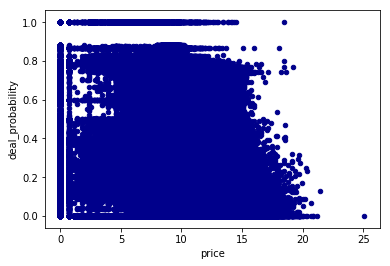

In [33]:
df_md1.plot.scatter(x='price', y='deal_probability', c='DarkBlue')
plt.show()



### Pair plot features. 
I wanted to see if there are any correlations between the various features used in model_1 tabular data. From the graphs below there doesn't seem to be any 'obvious' correlations. The day vs. other features plot is a good confirmation to the info about the taining dataset is mostly from last two week of the months 

In [34]:
df_md1.columns

Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'title', 'price', 'item_seq_number',
       'activation_date', 'image_top_1', 'deal_probability',
       'category_name_en', 'parent_category_name_en', 'region_en', 'month',
       'day', 'year', 'user_type_Company', 'user_type_Private',
       'user_type_Shop', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'region_encd', 'city_encd',
       'parent_category_name_encd', 'category_name_encd', 'param_1_encd',
       'param_2_encd', 'image_top_1_encd'],
      dtype='object')

CPU times: user 3min 10s, sys: 12.3 s, total: 3min 22s
Wall time: 3min 8s


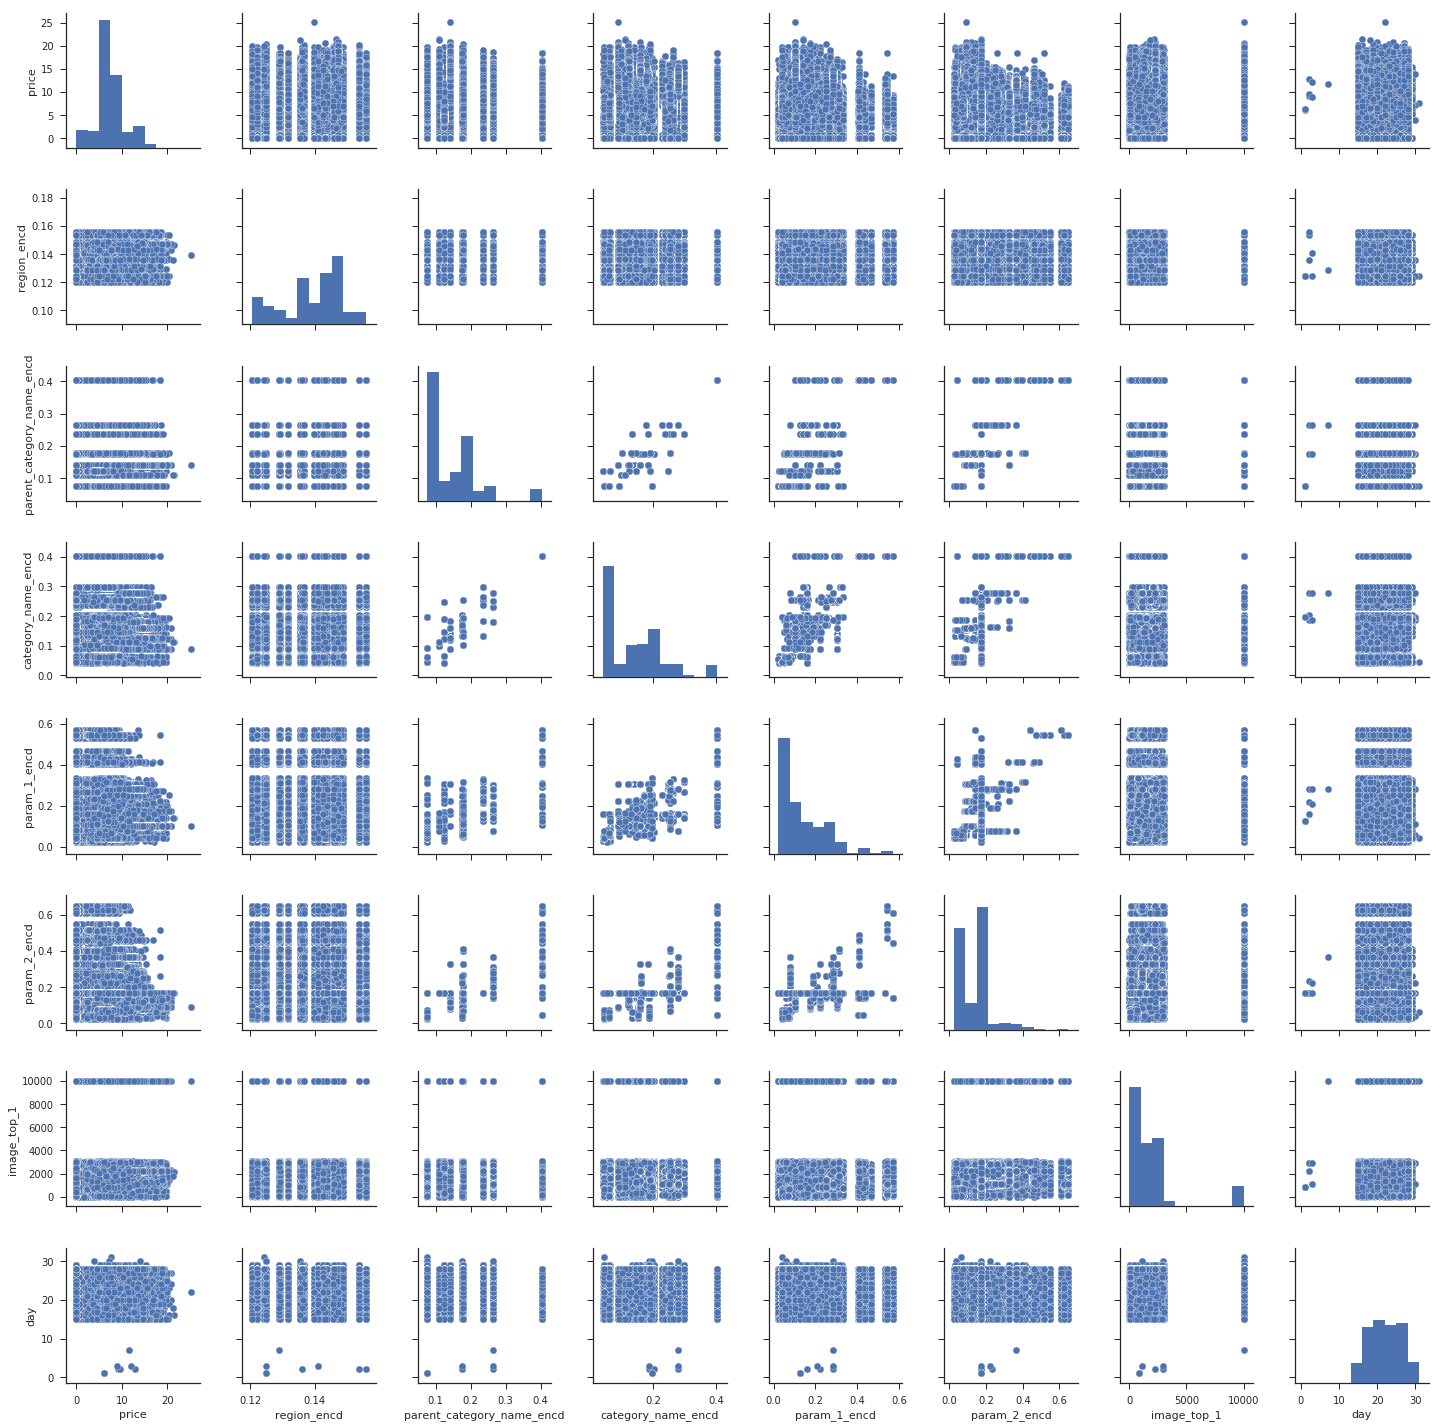

In [35]:
%%time
%matplotlib inline
import seaborn as sns; 
sns.set(style="ticks", color_codes=True)
#['region','city','parent_category_name','category_name','param_1','param_2','image_top_1']
sns.pairplot(df_md1[['price','region_encd','parent_category_name_encd',
                         'category_name_encd','param_1_encd','param_2_encd','image_top_1','day']])

### Predictiveness of individual features.
I wanted to understand the predictiveness of individual features by themselves. Below cell contains code that takes one feature at a time and predicts the deal_probability. For this, I split the training data into two groups (train and test). I wanted to better understand if there are any particular features that are 'more' predictive than 'other'. The metric I used is RMSE and used a simple DecisionTreeRegressor to fit and predict. The results show that there isn't any one particular feature that out does the other. Most of the features RMSE scores are in the range of 0.23 to 0.25, with param_1_encd rmse_score being the lowest. I am using this as my "benchmark" and setting expectations that the combined models will perform better compared to these RMSE scores

In [36]:
#Feature relevance
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
import math

seed=18

def split_data(train_data,target):
    # Split the data 
    x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                        target, 
                                                        test_size = 0.2, 
                                                        random_state = seed)
    return x_train,x_test,y_train,y_test

def train_predict(learner,x_train,x_test,y_train,y_test):
        
        learner.fit(x_train,y_train)
        #predict on X_test
        y_pred = learner.predict(x_test)
        # score of the prediction using the testing set
        rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
        return rmse_score
        
def predict_using_single_feature(df,cols):
    for col in cols:
        #get the feature column
        train_data = df[col];
        targetCol = df['deal_probability']
        regressor = DecisionTreeRegressor(random_state=seed)
         # Split the data 
        x_train,x_test,y_train,y_test = split_data(train_data,targetCol)
        print(col,'rmse_score:', train_predict(regressor,x_train.values.reshape(-1,1),x_test.values.reshape(-1,1),y_train,
                                               y_test))

def predict_using_single_feature_onehot_encd(df,cols):
    for onehot_encd_col in cols:
        #get the corresponding feature columns
        train_data = df[[c for c in df.columns if onehot_encd_col in c ]];
        targetCol = df['deal_probability']
        regressor = DecisionTreeRegressor(random_state=seed)
        
         # Split the data 
        x_train,x_test,y_train,y_test = split_data(train_data,targetCol)
        print(onehot_encd_col,'rmse_score:', train_predict(regressor,x_train.values,x_test.values,y_train,
                                               y_test))


#Check for predictablity of target variable by individual feature

cols_list = [col for col in df_md1.columns if 'encd' in col]
cols_list.append('price')

predict_using_single_feature(df_md1,cols_list)
predict_using_single_feature_onehot_encd(df_md1,['user_type','weekday'])


region_encd rmse_score: 0.26023553047670034
city_encd rmse_score: 0.26001997100228874
parent_category_name_encd rmse_score: 0.24792577248727493
category_name_encd rmse_score: 0.24400368399239905
param_1_encd rmse_score: 0.2395042495362975
param_2_encd rmse_score: 0.2445125286106418
image_top_1_encd rmse_score: 0.2453636157599596
price rmse_score: 0.2557172645842084
user_type rmse_score: 0.25955621357839687
weekday rmse_score: 0.2603746342948632


### Transforming Textual data (Title Column)
Used TF-IDF and SVD to transform title column  

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_selection import SelectPercentile,f_regression

tfid_vectorizer = TfidfVectorizer(sublinear_tf=True,max_df=0.5)   

#sklearn - Learn vocabulary and idf, return term-document matrix.
df_title_tfidf = tfid_vectorizer.fit_transform(df_md1.title.append(df_tst_md1.title)) 
df_md1_tfidf = tfid_vectorizer.transform(df_md1.title)
df_tst_md1_tfidf = tfid_vectorizer.transform(df_tst_md1.title)




In [38]:
#http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/
#Using svd technique to reduce the dimensionality of tdidf vector
from sklearn.decomposition import TruncatedSVD

#an initial guess for number of SVD components. My primary motivation is to keep the number of columns of
# model_1 relatively small, to avoid memory constraints.
num_comp = 4
svd = TruncatedSVD(n_components=num_comp, n_iter=10, random_state=seed)
svd.fit(df_title_tfidf)

df_md1_svd = svd.transform(df_md1_tfidf)
df_tst_md1_svd = svd.transform(df_tst_md1_tfidf) 


In [39]:
#check predictability of target variable based on the 4 components of the SVD of the Title column
regressor = DecisionTreeRegressor(random_state=0)

#Expand the 4 tuple returned from split_data into individual arguments by putting a * in front of the tuple
print('Title SVD components rmse_score:',train_predict(regressor,*split_data(df_md1_svd,df_md1['deal_probability'])))


Title SVD components rmse_score: 0.2800957567533413


In [40]:
#Join the svdcolumns to df_md1 and df_tst_md1

# def join_svd_cols(df,df_svd):
#     svd_columns = ['svd_title_'+str(i+1) for i in range(df_svd.shape[1])]
#     #set the index of the svd dataframe to be the same as df_md1. This will help concatenate both the dataframes correctly
#     df_title_svd = pd.DataFrame(data=df_svd,columns=svd_columns,index=df.index)
#     df = pd.concat([df,df_title_svd],axis=1)
#     return df

def join_svd_cols(df,df_svd,num_cols,col_prefix):
    svd_columns = [col_prefix+str(i+1) for i in range(num_cols)]
    #set the index of the svd dataframe to be the same as df_md1. This will help concatenate both the dataframes correctly
    df_title_svd = pd.DataFrame(data=df_svd[:,:num_cols],columns=svd_columns,index=df.index)
    #df_title_svd = pd.DataFrame(data=df_svd[svd_columns],columns=svd_columns,index=df.index)
    df = pd.concat([df,df_title_svd],axis=1)
    return df

#df_md1 = join_svd_cols(df_md1,df_md1_svd)
#df_tst_md1 = join_svd_cols(df_tst_md1,df_tst_md1_svd)

df_md1 = join_svd_cols(df_md1,df_md1_svd,df_md1_svd.shape[1],'svd_title_')
df_tst_md1 = join_svd_cols(df_tst_md1,df_tst_md1_svd,df_tst_md1_svd.shape[1],'svd_title_')


In [41]:
df_md1.columns
df_tst_md1.columns


Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'title', 'price', 'item_seq_number',
       'activation_date', 'image_top_1', 'category_name_en',
       'parent_category_name_en', 'region_en', 'month', 'day', 'year',
       'user_type_Company', 'user_type_Private', 'user_type_Shop', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'region_encd', 'city_encd', 'parent_category_name_encd',
       'category_name_encd', 'param_1_encd', 'param_2_encd',
       'image_top_1_encd', 'svd_title_1', 'svd_title_2', 'svd_title_3',
       'svd_title_4'],
      dtype='object')

#### Helper functions to select different columns from dataframe. 


In [42]:

# def get_categorical_cols(df):
#     d_cols = [col for col in df.columns if 'numeric'in col or 'user_type' in col or 'weekday' in col]
#     return d_cols

# def get_categorical_svd_cols(df):
#     d_cols = [col for col in df.columns if 'numeric'in col or 'user_type'in col or 'weekday' in col or 'svd_title' in col]
#     return d_cols

def get_categorical_encd_cols(df):
    d_cols = [col for col in df.columns if 'encd'in col or 'user_type' in col or 'weekday' in col]
    return d_cols


def get_categorical_encd_svd_cols(df):
    d_cols = [col for col in df.columns if 'encd'in col or 'user_type'in col or 'weekday'in col or 'svd_title' in col]
    return d_cols

def add_price(cols):
    cols.append('price')
    return cols

# def get_categorical(df):
#     cols = get_categorical_cols(df)
#     return add_price(cols)
   

# def get_categorical_title_svd(df):
#     cols = get_categorical_svd_cols(df)
#     return add_price(cols)

def get_categorical_encd(df):
    cols = get_categorical_encd_cols(df)
    return add_price(cols)
   

def get_categorical_encd_title_svd(df):
    cols = get_categorical_encd_svd_cols(df)
    return add_price(cols)



#print('categorical.{}'.format(get_categorical(df)))
#print('categorical_svd.{}'.format(get_categorical_title_svd(df)))
print('categorical_encd.{}'.format(get_categorical_encd(df_md1)))
print('Columns in categorical_encd_title_svd \n{}'.format(get_categorical_encd_title_svd(df_md1)))







categorical_encd.['user_type_Company', 'user_type_Private', 'user_type_Shop', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'region_encd', 'city_encd', 'parent_category_name_encd', 'category_name_encd', 'param_1_encd', 'param_2_encd', 'image_top_1_encd', 'price']
Columns in categorical_encd_title_svd 
['user_type_Company', 'user_type_Private', 'user_type_Shop', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'region_encd', 'city_encd', 'parent_category_name_encd', 'category_name_encd', 'param_1_encd', 'param_2_encd', 'image_top_1_encd', 'svd_title_1', 'svd_title_2', 'svd_title_3', 'svd_title_4', 'price']


### Below methods evaluate various learners on the tabular data. 
Used this step to help identify which learner I want to futher enhance and use as the "final" model for the tabular data. From the nanodegree program, I was aware of the Logistic, Linear Regression learners, but wasn't aware of the XGB algorithm. From kaggle, I read about how XGB algorithm is a very popular choice for winning competitions. I read quite a bit about how the XGB works and all the various parameters involved in tuning it. As an initial attempt, I used the "default" setting of XGB to compare it with Logistic and Linear regression. From the initial RMSE scores, it became clear that XGB performs much better than the other two. So, I chose XGB as the model that I wanted to concentrate on and use it as my learner for model_1

In [43]:
%%time
from xgboost import xgboost as xgb 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

#get transformed columns of data
def get_md1_data(df):
    d_cols = get_categorical_encd_title_svd(df)
    md1_data = df[d_cols]
    print ('Shape of selected columns train data', md1_data.shape)
    return md1_data

def eval_learners(train_data,target_data,learner_list):
    
    for learner in learner_list:
        print(learner.__class__.__name__, 'rmse_score:',train_predict(learner,*split_data(train_data.values,target_data)))

if flg_mdl_1:
    dt_reg = DecisionTreeRegressor(random_state=seed)
    gbm_reg = xgb.XGBRegressor(max_depth=4, n_estimators=500)
    log_reg = LogisticRegression(random_state=seed)
    lin_reg = LinearRegression()
    learner_list = [lin_reg,dt_reg,gbm_reg]
    eval_learners(get_md1_data(df_md1),df_md1['deal_probability'],learner_list)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 7.39 ms


In [44]:
#helper function to generate submission file for kaggle
def generate_submission_csv(test_data,y_pred,filename):
    df_submission = pd.DataFrame({'item_id': test_data.index, 'deal_probability': y_pred})
    df_submission.loc[df_submission.deal_probability < 0,'deal_probability'] = 0.0
    df_submission.loc[df_submission.deal_probability > 1, 'deal_probability'] = 1.0
    #ensure that the order is set for submission
    df_submission =  df_submission[['item_id','deal_probability']]
    df_submission.to_csv(filename, index=False)
    return df_submission

### Linear Regression (Benchmark) model submission and RMSE score

As proposed, I am using linear Regression model to generate predictions on the test data. 


In [45]:
if flg_mdl_1:
    y_pred = lin_reg.predict(get_md1_data(df_tst_md1))
    generate_submission_csv(df_tst_md1,y_pred,'benchmark_mdl_submission.csv')

<b>Screenshots of the benchmark model submission and the RMSE score from kaggle on the test data.</b>


![submission_cl](rpt_imgs/Screen%20Shot%202018-06-13%20at%209.47.33%20AM.png)

![rmse score](rpt_imgs/Screen%20Shot%202018-06-13%20at%209.49.53%20AM.png)


My benchmark model RMSE score is 0.2410. Expectation is that my other models perform similar or better than the benchmark model 

### Tuning XGBM for better performance.

With an initial set of values (booster_params), I performed cv on the training data to determine the best number of estimators needed. Below is the screen shot of Feature score based on the criteria. The number of estimators for this set of params was 472.


![XGB Feature Score](rpt_imgs/xgbm_feat_imp.png)


Once I had this, I intended to use grid search to further fine tune some parameters (especially max_depth and min_child_weight to avoid over fitting). Due to limitations of the aws instance, the grid search did not successfully run to completion. I terminated the run after 9 hours. Unfortunately, there was no intermediate results that I could have used. For pedagogical purposes, I ran the grid search for a small training set (~5000 records). Below is the snapshot of the optimized scores of the grid search. From the output of the optimized scores, the combination of 3 and 5 for max_depth and min_child_weight had the lowest score. I have decided to use these values for my model_1


![Optimized Grid Scores](rpt_imgs/optim_grid_scores.png)




In [46]:
%%time

%matplotlib inline
import seaborn as sns

def xgboost_mdl_cv(x_train,y_train,booster_params):
  
    xgdmat = xgb.DMatrix(x_train, y_train) # Create DMatrix to make XGBoost more efficient

    # get the best number of estimators with the given settings. xgb.cv performs crossvalidation 
    cv_xgb = xgb.cv(params = booster_params, dtrain = xgdmat, num_boost_round = 1000, nfold = 5,
                    metrics = ['error'], 
                    early_stopping_rounds = 50) 
    mdl_1_xgb = xgb.train(booster_params, xgdmat, num_boost_round = cv_xgb.shape[0])
    #plot feature importance
    sns.set(font_scale = 1.5)
    xgb.plot_importance(mdl_1_xgb)
    return cv_xgb,mdl_1_xgb

#df_md1_train = df_md1.sample(750000)
df_md1_train = df_md1

print (df_md1.columns)

booster_params = {'eta': 0.3, 'seed':seed, 'subsample': 1.0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':3} 

if flg_mdl_1:
    cv_xgb,mdl_1_xgb = xgboost_mdl_cv(get_md1_data(df_md1_train),df_md1_train['deal_probability'],booster_params)


Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'title', 'price', 'item_seq_number',
       'activation_date', 'image_top_1', 'deal_probability',
       'category_name_en', 'parent_category_name_en', 'region_en', 'month',
       'day', 'year', 'user_type_Company', 'user_type_Private',
       'user_type_Shop', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'region_encd', 'city_encd',
       'parent_category_name_encd', 'category_name_encd', 'param_1_encd',
       'param_2_encd', 'image_top_1_encd', 'svd_title_1', 'svd_title_2',
       'svd_title_3', 'svd_title_4'],
      dtype='object')
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.55 ms


In [47]:
#save the model 
from sklearn.externals import joblib

if flg_mdl_1:
    joblib.dump(mdl_1_xgb, "saved_models/mdl_1_xgb.joblib.dat")

In [48]:
if flg_mdl_1:
   print(cv_xgb.shape[0])

In [49]:
%%time
from sklearn.grid_search import GridSearchCV

#Parameter tuning using Gridsearch. 
if flg_mdl_1 and flg_mdl_1_xgb_gridsearch:
    df_md1_sample = df_md1.sample(5000)
    estimators = cv_xgb.shape[1]
    #cv_params = {'max_depth': [3,5], 'min_child_weight': [3,5,7],'learning_rate':[0.2,0.3]} 
    cv_params = {'max_depth': [3,5,6], 'min_child_weight': [3,5]} 
    ind_params = {'n_estimators': cv_xgb.shape[0], 'seed':seed, 'subsample': 1.0, 'colsample_bytree': 1.0, 
                 'objective': 'binary:logistic'}
    optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                                cv_params, 
                                 scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1) 

    optimized_GBM.fit(get_md1_data(df_md1_sample).values,df_md1_sample['deal_probability'])
    print (optimized_GBM.grid_scores_)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.45 ms


/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [50]:
if flg_mdl_1 and flg_mdl_1_xgb_gridsearch:
    optimized_GBM.grid_scores_

In [51]:
#predict for test data using the tuned XGBM model
if flg_mdl_1:
    testdmat = xgb.DMatrix(get_md1_data(df_tst_md1))
    y_pred = mdl_1_xgb.predict(testdmat)
    generate_submission_csv(df_tst_md1,y_pred,'md1_submission.csv')


<b>Screenshots of the model_1 using XGBM submission and the RMSE score from kaggle on the test data.</b>


![Screen%20Shot%202018-06-13%20at%209.57.26%20AM.png](rpt_imgs/Screen%20Shot%202018-06-13%20at%209.57.26%20AM.png)

![Screen%20Shot%202018-06-13%20at%2010.03.44%20AM.png](rpt_imgs/Screen%20Shot%202018-06-13%20at%2010.03.44%20AM.png)

RMSE score of the XGBM model is 0.2302 (an improvement from the benchmark model!)



### Processing Description Column data for model 2 of the project

Following were the steps performed to prepare the description column data

* Filled in a place holder value for the missing description column of both train and test datasets
* Used TFIDF and SVD to tranform the textual data to numerical data
* For SVD, experimented with n_components=100 and 125, to see the impact on the prediction score. (sklearn documentation recommends 100 components for Latent Semantic Analysis). Did not experiment with a wider range due to concerns about hardware limitations,long training time and aws expense. 

In [52]:
# compute the percent of missing data
print ('Missing Train data *******************************')  
cols_with_missing_data(df_md2)

print ('Missing Test data *******************************')  
cols_with_missing_data(df_tst_md2)

Missing Train data *******************************
description has 7.734079008982163 of data missing
Missing Test data *******************************


In [53]:
def md2_fill_missing_desc(df_train, df_test):
    #Replace blank description with 'placeholder' word
    df_train_1 = df_train[['description']].fillna('заполнитель')#.sum().sum()
    df_test_1 = df_test[['description']].fillna('заполнитель')#.sum().sum()
    return df_train_1, df_test_1

#df_md2 = (df_train[['item_id','description','deal_probability']]).set_index('item_id')
#df_tst_md2 = (df_test[['item_id','description']]).set_index('item_id')

print ('Before: Number of missing values in df_md2', df_md2.isnull().sum().sum())
print ('Before: Number of missing values in df_tst_md2', df_tst_md2.isnull().sum().sum())
df_md2['description'],df_tst_md2['description'] = md2_fill_missing_desc(df_md2,df_tst_md2)
print ('After: Number of missing values in df_md2', df_md2.isnull().sum().sum())
print ('After: Number of missing values in df_tst_md2', df_tst_md2.isnull().sum().sum())



Before: Number of missing values in df_md2 116276
Before: Number of missing values in df_tst_md2 0
After: Number of missing values in df_md2 0
After: Number of missing values in df_tst_md2 0


In [54]:
df_md2_corpus_tfidf = tfid_vectorizer.fit_transform(df_md2.description.append(df_tst_md2.description)) 
df_md2_tfidf = tfid_vectorizer.transform(df_md2.description)
df_tst_md2_tfidf = tfid_vectorizer.transform(df_tst_md2.description)
print('Terms in the corpus ', df_md2_corpus_tfidf.shape[1])
print('Dimensions of df_md2_corpus_tfidf ', df_md2_corpus_tfidf.shape)
print('Dimensions of df_md2_tfidf ', df_md2_tfidf.shape)
print('Dimensions of df_tst_md2_tfidf ', df_tst_md2_tfidf.shape)


Terms in the corpus  725200
Dimensions of df_md2_corpus_tfidf  (2011862, 725200)
Dimensions of df_md2_tfidf  (1503424, 725200)
Dimensions of df_tst_md2_tfidf  (508438, 725200)


In [55]:
%%time
#get the svd components of the tf-idf vectors
#num_comp based on the recommendations from the sklearn documentation for LSA. Experimented with 100 and 125.
num_comp = 125 #100
md2_svd = TruncatedSVD(n_components=num_comp, n_iter=10, random_state=seed)
md2_svd.fit(df_md2_corpus_tfidf)
df_md2_svd = md2_svd.transform(df_md2_tfidf)
df_tst_md2_svd = md2_svd.transform(df_tst_md2_tfidf) 

CPU times: user 9min 34s, sys: 1min 29s, total: 11min 3s
Wall time: 6min 46s


### Neural Net model used for model 2 

The model uses 2 layers with 64 nodes in each layer. I am using 'relu' activation instead of sigmoid to address diminishing gradient issue typically seen with sigmoid activation function. As the output is a continuous target variable, the last layer of the net is a single neuron with a sigmoid activation function.


In [56]:

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint 
#create keras model

def nn_model(units,input_dim):
    model = Sequential()
    model.add(Dense(units=units, activation='relu', input_dim=input_dim))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(1, activation='sigmoid',kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #print (model.summary())
    return model



Using TensorFlow backend.


In [57]:
df_md2.columns

Index(['description', 'deal_probability'], dtype='object')

### Training the Net

Used the ModelCheckpoint function to save the 'best' model.

Number of epochs to train the net: I started small (around 15 epochs) and went upto 45 epochs, during development stages of the code. I noticed that the val_loss stopped improving anywhere after 20 epochs. So, for this submission, I used 30 epochs. 





In [58]:
%%time
from keras.callbacks import ModelCheckpoint  

def train_nn(model,x_train,x_val,y_train,y_val,epochs,batch_size,saved_mdl_name):
    #x_train, x_val,y_train, y_val = split_data(train_x,train_y)
    checkpointer = ModelCheckpoint(filepath='saved_models/'+saved_mdl_name, 
                               verbose=1, save_best_only=True)
    model.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer],verbose=1)
    
if flg_mdl_2:
    mdl_2_nn = nn_model(64,df_md2_svd.shape[1])  
    x_train, x_val,y_train, y_val = split_data(df_md2_svd, df_md2['deal_probability'])
    train_nn(mdl_2_nn, x_train, x_val,y_train, y_val,30,128,'mdl_2_tfidf_best_model.hdf5')
    mdl_2_nn.load_weights('saved_models/mdl_2_tfidf_best_model.hdf5')
    y_pred = mdl_2_nn.predict(df_tst_md2_svd)
    generate_submission_csv(df_tst_md2,y_pred.flatten(),'md2_submission.csv')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs


<b>Screenshots of the model_2 using NN submission and the RMSE score from kaggle on the test data.</b>

As I expected, the RMSE score of the model_2 is higher compared to benchmark. As model_2 is ONLY using description column data, it does not perform very well in predicting the target variable

![Screen%20Shot%202018-06-13%20at%2011.18.29%20AM.png](rpt_imgs/Screen%20Shot%202018-06-13%20at%2011.18.29%20AM.png)

![Screen%20Shot%202018-06-13%20at%2011.23.19%20AM.png](rpt_imgs/Screen%20Shot%202018-06-13%20at%2011.23.19%20AM.png)

In [59]:
#helper functions to save and load nn model
from keras.models import model_from_json

def save_nn_model(nn_mdl,mdl_filename):
    nn_mdl_json = nn_mdl.to_json()
    with open(mdl_filename, "w") as json_file:
        json_file.write(nn_mdl_json)
        
def open_load_nn_model(mdl_filename,wts_filename):
    json_file = open(mdl_filename, 'r')
    nn_json = json_file.read()
    json_file.close()
    nn_mdl = model_from_json(nn_json)
    nn_mdl.load_weights(wts_filename)
    return nn_mdl


In [60]:
#save nn model

from keras.models import model_from_json
if flg_mdl_2:
    save_nn_model(mdl_2_nn,"saved_models/mdl_2_nn.json")


### Combining Model 1 and Model 2. 

* Model 1 - trained with tabular data using XGBM
* Model 2 - trained with description data using NN

I experimented with how best to combine these two models.  I evaluated linear, xgbm and a NN model. I got the best training RMSE score for the XGBM model. 

In [61]:
#combibe outputs from md1,md2 and md3
#input is a list with df. Each df has two columns (index and deal_probability)

def combine_mdl_outputs(df_list,join):
    df = df_list[0]
    for df_i in df_list[1:]:
        df = df.merge(df_i, on='item_id',how=join)#'outer')
    return df


In [62]:
%%time
#THIS STEP IS TO TRAIN THE COMBINED MODEL. 

from tqdm import tqdm

def get_mdl_1_xgb_predictions(model,df):
    mdl_dmat = xgb.DMatrix(get_md1_data(df))
    y_pred = model.predict(mdl_dmat)
    return pd.DataFrame({'item_id': df.index, 'deal_probability_1': y_pred})

def get_mdl_2_nn_predictions(model,df,df_svd):
    y_pred = model.predict(df_svd)
    return pd.DataFrame({'item_id': df.index, 'deal_probability_2': y_pred.flatten()})

def get_mdl_3_cnn_predictions(model,df,hdf5_file):
    
    hdf_fh = h5py.File (hdf5_file)  
    #process hdf5_file in batch sizes
    batch_size = 1024
    num_iters = math.ceil(df.shape[0]/batch_size)
    pred_array = np.array([])
    
    for i in tqdm(range(0,num_iters)):
        st_idx = i*batch_size;
        end_idx = (i*batch_size+batch_size)
        #print ('start_idx',st_idx, 'end_idx',end_idx)
        #y_pred = model.predict(np.asarray(HDF5Matrix(hdf5_file, 'img_dset',start=st_idx,end=end_idx)))
        y_pred = model.predict(np.asarray(hdf_fh['img_dset'][st_idx:end_idx]))
        pred_array = np.append(pred_array, y_pred.flatten())
 
    return pd.DataFrame({'item_id': df.index, 'deal_probability_3': pred_array})





CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.7 ms


### Train the combined model 

In [63]:

#get predictions on the train data of the individual models.
#use this to train the combined model

if flg_cmb_two_mdls :
    #load saved models
    #load xgb mdl
    mdl_1_xgb = joblib.load("saved_models/mdl_1_xgb.joblib.dat")   
    # load nn mdl
    mdl_2_nn = open_load_nn_model('saved_models/mdl_2_nn.json','saved_models/mdl_2_tfidf_best_model.hdf5')

    #get train predictions for the respective models
    
    df_y1 = get_mdl_1_xgb_predictions(mdl_1_xgb,df_md1)
    df_y2 = get_mdl_2_nn_predictions(mdl_2_nn,df_md2,df_md2_svd)
    
    #combine the train preditions from the models
    df_train_combined = combine_mdl_outputs([df_y1,df_y2],'outer').set_index('item_id')

    #create an initial set of learners, evaluate based on rmse score
    print (df_train_combined.shape)
    cmb_lin_reg = LinearRegression()
    cmb_gbm_reg = xgb.XGBRegressor(max_depth=4, n_estimators=50)
    learner_list = [cmb_lin_reg,cmb_gbm_reg]
    eval_learners(df_train_combined,df_md1['deal_probability'],learner_list)
    print ('linear model coef: ', cmb_lin_reg.coef_, ' intercept: ', cmb_lin_reg.intercept_)




#### Measuring Robustness of the combined model

Below is the cross-validation code to measure how comparable the RMSE  of the model is on train data set vs. test data set.From the results below (Train data - 0.2227 vs. Test data RMSE - 0.2293), it can be seen that the scores are close to each other.

In [64]:
%%time

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

if flg_cmb_two_mdls :
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(cmb_gbm_reg, df_train_combined, df_md1['deal_probability'], cv=kfold,scoring = 'neg_mean_squared_error')
    print ("CV results: ", results)
    print("MSE: %0.4f (+/- %0.4f)" % (results.mean(), results.std() * 2))
    print("RMSE : %0.4f" % math.sqrt(abs(results.mean())))
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.5 µs


### Submit results from combined model_1 and model_2

Both Linear and XGB Regressor RMSE scores from training are very comparable (0.2230 and 0.2228 repectively). Along with these two models, used a NN to combine the two models as well. Submitted test predictions from all three combined models 

In [65]:

if flg_cmb_two_mdls:
    #get individual predictions from model 1
    df_tst_y1 = get_mdl_1_xgb_predictions(mdl_1_xgb,df_tst_md1)
   
    #get individual predictions from model 2
    df_tst_y2 = get_mdl_2_nn_predictions(mdl_2_nn,df_tst_md2,df_tst_md2_svd)

    df_tst_combined = combine_mdl_outputs([df_tst_y1,df_tst_y2],'outer').set_index('item_id')

    #get final predicitons and generate submission file
    y_final_pred = cmb_lin_reg.predict(df_tst_combined)
    generate_submission_csv(df_tst_md1,y_final_pred,'combined_linear_submission.csv')

    y_final_pred_2 = cmb_gbm_reg.predict(df_tst_combined.values)
    generate_submission_csv(df_tst_md1,y_final_pred_2,'combined_xgb_submission.csv')


In [66]:
#Try a nn for combining outputs of both the models 

if flg_cmb_two_mdls:
   
    cmb_nn = nn_model(4,df_train_combined.shape[1])
    x_train, x_val,y_train, y_val = split_data(df_train_combined.values,df_md1['deal_probability'])
    train_nn(cmb_nn,x_train, x_val,y_train, y_val,20,128,'cmb_mdl_nn.hdf5')
    cmb_nn.load_weights('saved_models/cmb_mdl_nn.hdf5')
    #get predictions on the test data
    y_final_pred_3 = cmb_nn.predict(df_tst_combined.values)
    generate_submission_csv(df_tst_md1,y_final_pred_3.flatten(),'combined_nn_submission.csv')




<b> Screenshots of the combined models (Linear, XGB, NN) submission and the RMSE score from kaggle on the test data. </b>

![Screen%20Shot%202018-06-13%20at%201.27.13%20PM.png](rpt_imgs/Screen%20Shot%202018-06-13%20at%201.27.13%20PM.png)

![Screen%20Shot%202018-06-14%20at%208.36.16%20AM.png](rpt_imgs/Screen%20Shot%202018-06-14%20at%208.36.16%20AM.png)


From the RMSE scores, all three models are very comparable. 



### Exploring single model for tabular data and description data

During model building process, I wanted to experiment with combining the tabular data with the top 'x' svd components of the description into one dataset and use xgbm model to train and predict. I wanted to compare how the RMSE score was with my original proposed model vs. one unified model. 

My motivation was to see if using a limited set of svd components of the description and using a singlular model, will have a significant change in the RMSE of the models. This would be important to know, because, in a production environment, if the difference in RMSE scores is 'tolerable', based on some business requirements, I would opt for a unified model, instead of the two model approach as it would be a simpler solution. 



In [67]:
%%time

def get_mdl_1_alt_data(df):
    #add svd_desc columns as well
    d_cols = get_categorical_encd_title_svd(df) + [col for col in df.columns if 'svd_desc'in col]
    md1_data = df[d_cols]
    return md1_data


#experiment combining both the tabular data and the top 20 components of the svd vectors and run it thru xgb
if flg_alt_unified_desc_tabular_data:
    df_mdl_1_alt = join_svd_cols(df_md1,df_md2_svd,20,'svd_desc_')
    df_tst_mdl_1_alt = join_svd_cols(df_tst_md1,df_tst_md2_svd,20,'svd_desc_')

    booster_params = {'eta': 0.3, 'seed':seed, 'subsample': 1.0, 'colsample_bytree': 0.8, 
                 'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':3} 

    cv_alt_xgb,mdl_1_alt_xgb = xgboost_mdl_cv(get_mdl_1_alt_data(df_mdl_1_alt),df_mdl_1_alt['deal_probability'],booster_params)
    joblib.dump(mdl_1_alt_xgb, "saved_models/mdl_1_alt_xgb.joblib.dat")
    testdmat = xgb.DMatrix(get_mdl_1_alt_data(df_tst_mdl_1_alt))
    y_pred = mdl_1_alt_xgb.predict(testdmat)
    generate_submission_csv(df_tst_mdl_1_alt,y_pred,'mdl_1_alt_submission.csv')



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


In [68]:
#cv_alt_xgb.shape

<b> Screenshots of the unified XGB model Feature score, submission and the RMSE score from kaggle on the test data.</b>


![Screen%20Shot%202018-06-14%20at%2010.15.03%20AM.png](rpt_imgs/Screen%20Shot%202018-06-14%20at%2010.15.03%20AM.png)


![Screen%20Shot%202018-06-14%20at%2010.18.22%20AM.png](rpt_imgs/Screen%20Shot%202018-06-14%20at%2010.18.22%20AM.png)

![Screen%20Shot%202018-06-14%20at%2010.14.49%20AM%202.png](rpt_imgs/Screen%20Shot%202018-06-14%20at%2010.14.49%20AM%202.png)


The RMSE score on the test data is higher compared to the combined models in the fourth decimal place. It makes sense, because this model uses about 1/5th of description svd data. However, as mentioned above, in production setting, if this meets the business requirements threshold, it would be worth pursuing it and experiment further to fine tune the num svd components to improve the rmse score. 

### Processing image data for Model 3

Processing the entire training image data (1.3 million images) turned out to be VERY resource intensive task. To get the images from kaggle, and unzip alone used up about 40 GBs of data. 

<b> Converting and storing the image arrays</b>
With the large volume of images in the training dataset, I was not able to store the image arrays in the RAM. My initial approach was to use a different instance of aws with bigger RAM. I changed the aws instance to p2.8xlarge instance 2ith 488 GiB of RAM , but I still ran into memory constraints. Then,I started exploring options available in python to handle large volume datasets and learned about h5py. Used h5py to convert the images to image arrays and store the hp5y file on hard disk. This was a a very time consuming task. It took about 6-8 hours to process the training dataset and testing dataset and used about 600GB of hard disk.

Next, I wrote helper methods (e.g Generator method that reads from the h5py file into RAM during training) to get chuncks of data that the RAM can handle.

<b> Hurdles with the volume of training data </b>
With training data processed and stored as hdf5 file and functions to read the file in chunks, I started to train the CNN. Unfortunately, single epoch was taking more than a few hours. After letting it run overnight and not seeing very promising results (i.e., the net was running its second epoch), I decided to terminate the process. Because at this rate, training would have taken days and my aws expenses would be really high.  

Then, I decided to use smaller training data set. I was hoping that about 500K images should work faster. However, this did not speed up the process either. This was still taking in the order of hours to go thru a single epoch.

As my final attempt, I used a very small training data set (about 6000 images). I chose this number because, the Dog Classifier project used about 6000 images and the current aws instance ran quickly on this set. I know the accuracy may not be good and the combined model may not be very predictive. But, I wanted to do this as an academic exercise. 

As a side note, this exercise made me appreciate the idea of transfer learning more, where a user can take and apply the learnings of pre-trained network.



In [69]:
#Model 3 will process the image data. convert_to_tensor and image_to_tensor helper functions are from udacity dog-breed predictor project

from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
import h5py

def convert_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    return x
    
#given image paths, load/convert image and write it to hdf5 dataset
def image_to_tensor_hdf5(img_fh,img_dset,img_paths,tgt_dset=None,tgt_col=None):
    i=0
    for img_path in tqdm(img_paths):
        img_dset[i] = convert_to_tensor(img_path).astype('float32')/255
        if ((tgt_dset is not None) and (tgt_col is not None)):
            tgt_dset[i] = tgt_col[i]
        #flush the buffer
        if (i%5000 == 0):
            img_fh.flush()
        i += 1

        
def preprocess_md3_data(df,dir_path):
    #remove missing images data
    #remove the additional zero byte images (data errors by Avito)
    # https://www.kaggle.com/liujilong/four-image-has-zero-size
    
    zero_size_img_files = ['4f029e2a00e892aa2cac27d98b52ef8b13d91471f613c8d3c38e3f29d4da0b0c', 
               '8513a91e55670c709069b5f85e12a59095b802877715903abef16b7a6f306e58', 
               '60d310a42e87cdf799afcd89dc1b11ae3fdc3d0233747ec7ef78d82c87002e83', 
               'b98b291bd04c3d92165ca515e00468fd9756af9a8f1df42505deed1dcfb5d7ae']
    
    df_filtered = df[(df.image.notnull()) & ~(df.image.isin(zero_size_img_files))]
    
    #add an additional column to hold the absolute path to the image
    df_filtered['imgPath'] = df_filtered.image.apply(lambda x: dir_path+x+'.jpg')
    
    return df_filtered


if flg_process_img:
    #due to resource constraint, working with a very small sample of training data. 
    sample_size = 5000
    df_md3_filtered = preprocess_md3_data(df_md3,'.kaggle/competitions/avito-demand-prediction/images/').sample(sample_size,random_state=seed)
    df_tst_md3_filtered = preprocess_md3_data(df_tst_md3,'.kaggle/competitions/avito-demand-prediction/test_jpg/')

    #split the training data into train and validate (80-20)
    df_md3_train = df_md3_filtered.iloc[:int(.8*sample_size)]
    df_md3_val = df_md3_filtered.iloc[int(.8*sample_size):]
    print (df_md3_train.shape)
    print (df_md3_val.shape)



In [70]:
%%time

#Due to memory constraints, using hdf5 file to save the processed images.
#The training and validation dataset both have two keys - img_dset and tgt_dset with dimensions (sample_size,244,244,3) and (sample_size,1,) respectively
#The testing dataset has one key - img_dset with dimensions (test_dataset_size,244,244,3)
def create_hdf5_file(filename,df,has_tgt=None):
    hdf5_fh = h5py.File(filename, "w")
    img_dset = hdf5_fh.create_dataset("img_dset", (len(df),224, 224,3))
    if ((has_tgt is not None)):
        target_dset = hdf5_fh.create_dataset("tgt_dset", (len(df),1))
        image_to_tensor_hdf5(hdf5_fh,img_dset,df['imgPath'],target_dset,df['deal_probability'])     
    else:
        #test data set does not have target predictions. 
        image_to_tensor_hdf5(hdf5_fh,img_dset,df['imgPath'])
    hdf5_fh.close()
    

if flg_process_img:
    create_hdf5_file('train_imgs.hdf5',df_md3_train,True)
    create_hdf5_file('val_imgs.hdf5',df_md3_val,True)
    #create_hdf5_file('tst_imgs.hdf5',df_tst_md3_filtered)



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [71]:
train_file = h5py.File ('./train_imgs.hdf5')
val_file = h5py.File ('./val_imgs.hdf5')
tst_file = h5py.File ('./tst_imgs.hdf5')
print ('train_file entries',train_file['img_dset'].shape[0])
print ('val_file entries',val_file['img_dset'].shape[0])
print ('shape of train file',train_file['img_dset'][0].shape)
print ('shape of tst file',tst_file['img_dset'][0].shape)




train_file entries 4000
val_file entries 1000
shape of train file (224, 224, 3)
shape of tst file (224, 224, 3)


In [72]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

#using the architecture from dog-breeder project. Modified thelast layer to be a 1 output layer 
#with a sigmoid function (as the target variable is continous between 0 and 1)
# and using loss function to be mean_squared_error 
def cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                            input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

#Reading from hdf5_matrix is NOT working!!
# def batch_generator_hdf_data(train_hdf5_matrix,tgt_hdf5_matrix,batch_size):
#     total_samples = train_hdf5_matrix.shape[0]
#     print ('total samples',total_samples)
#     train_tensors = []
#     tgt_tensors = []
#     while True:
#         for i in range (batch_size):
#             index= np.random.choice (total_samples, 1, replace = False)[0]
#             train_tensors.append(np.array(train_hdf5_matrix[index]))
#             tgt_tensors.append(np.array(tgt_hdf5_matrix[index]))
#         yield np.asarray(train_tensors), np.asarray(tgt_tensors)

#reads batch_size of img_array data and label_data from hdf5 file
#Ref: https://medium.com/@fromtheast/implement-fit-generator-in-keras-61aa2786ce98 and https://stackoverflow.com/questions/45579598/problems-with-fit-generator-with-a-big-hdf5-file
#Modified data set names for my purposes. 
def hdf5_batch_generator(hdf5_file, batch_size):

    total_samples = hdf5_file['img_dset'].shape[0]
    feature_instance_shape = list (hdf5_file['img_dset'][0].shape)
    feature_instance_shape.insert(0, batch_size)

    label_instance_shape = list (hdf5_file['tgt_dset'][0].shape)
    label_instance_shape.insert(0, batch_size)

    batch_features = np.zeros(feature_instance_shape)
    batch_response = np.zeros(label_instance_shape)

    while True:
        for i in range (batch_size):
            index= np.random.choice (total_samples, 1, replace = False)[0]
            batch_features[i] = np.array(hdf5_file['img_dset'][index])
            batch_response[i] = np.array(hdf5_file['tgt_dset'][index])
        yield batch_features, batch_response





In [73]:
%%time

#for 400K train samples, steps_per_epoch = 400000/128 = 3125
#for 100k val samples, validation_steps = math.ceil(100000/128)

#for 4000 train samples,
batch_size = 64
num_epoch_steps  = math.ceil(train_file['img_dset'].shape[0]/batch_size)
num_val_steps = math.ceil(val_file['img_dset'].shape[0]/batch_size)

print ('Num epoch steps: ', num_epoch_steps)
print ('Num val steps: ', num_val_steps)

if flg_eval_cnn_mdl:
    mdl_3_cnn = cnn_model(train_file['img_dset'][0].shape)

    checkpointer = ModelCheckpoint(filepath='saved_models/'+'mdl_3_cnn.hdf5', 
                                   verbose=1, save_best_only=True)
    #due to large amounts of image data, using fit_generator method to train the CNN. The generator and validation_data generator
    #help load only batch_size amount of data needed. 
    mdl_3_cnn.fit_generator(generator=hdf5_batch_generator(train_file, batch_size), 
                            steps_per_epoch=num_epoch_steps, nb_epoch=25,verbose=1,
                            validation_data=hdf5_batch_generator(val_file,batch_size),validation_steps=num_val_steps,callbacks=[checkpointer])
    # mdl_3_cnn.fit_generator(generator=batch_generator(train_file, 128), 
    #                         steps_per_epoch=1, nb_epoch=25,verbose=1,
    #                         validation_data=batch_generator(val_file,128),validation_steps=1,callbacks=[checkpointer])
    save_nn_model(mdl_3_cnn,"saved_models/mdl_3_cnn.json")

Num epoch steps:  63
Num val steps:  16
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.12 ms


In [74]:
%%time

if flg_eval_cnn_mdl:
    df_tst_y3 = get_mdl_3_cnn_predictions(mdl_3_cnn,df_tst_md3_filtered,'./tst_imgs.hdf5')


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs


In [75]:
#df_tst_y3.deal_probability_3.describe

### Generating test predictions using Model 3 (CNN trained on very limited number of training data points)
As a check, submitting predictions using ONLY model 3. Hypothesis is that the model will perform poorly (i.e.the RMSE is going to be high.) because the training set is severely limited. 

In [76]:
#merge the original test df with filtered df that was filtered for missing images and create a submission file
#fill the predicted prob = 0.0 for the rows with missing image
if flg_eval_cnn_mdl:
    df_tst_merge = df_tst_md3.reset_index().merge(df_tst_y3, on='item_id',how='outer')
    df_tst_merge = df_tst_merge[['item_id','deal_probability_3']]
    df_tst_merge.columns = ['item_id','deal_probability']
    df_tst_merge.deal_probability.fillna(0.0,inplace=True)
    df_tst_merge.loc[df_tst_merge.deal_probability < 0,'deal_probability'] = 0.0
    df_tst_merge.loc[df_tst_merge.deal_probability > 1, 'deal_probability'] = 1.0
    #ensure that the order is set for submission
    df_tst_merge =  df_tst_merge[['item_id','deal_probability']]
    df_tst_merge.to_csv('mdl3_submission.csv', index=False)


<b> Screenshots of the the RMSE score from kaggle on the test data.</b>

As expected, the RMSE score is high compared to all the other models (Benchmark, individual model 1 and model 2 and combined model 1 and 2 scores)

![Screen%20Shot%202018-06-12%20at%2012.52.56%20PM.png](rpt_imgs/Screen%20Shot%202018-06-12%20at%2012.52.56%20PM.png)

In [77]:
#get predictions on the training dataset.
#Use these outputs to train the combined model

#df_y3 = get_mdl_3_cnn_predictions(mdl_3_cnn,df_md3_train,'./train_imgs.hdf5')


In [78]:
#df_y3.deal_probability_3.mean()

### Combine all three models 

For training purposes of the combined model, limited the training set size to be 4000 data points, as this is number of train images I processed in the steps above 

In [79]:
%%time

if flg_cmb_three_mdls:
    #load saved models
    #load xgb mdl
    mdl_1_xgb = joblib.load("saved_models/mdl_1_xgb.joblib.dat")   
    # load nn mdl
    mdl_2_nn = open_load_nn_model('saved_models/mdl_2_nn.json','saved_models/mdl_2_tfidf_best_model.hdf5')
    #load cnn mdl
    mdl_3_cnn = open_load_nn_model('saved_models/mdl_3_cnn.json','saved_models/mdl_3_cnn.hdf5')
    
    #get train predictions for the respective models
    df_y1 = get_mdl_1_xgb_predictions(mdl_1_xgb,df_md1)
    df_y2 = get_mdl_2_nn_predictions(mdl_2_nn,df_md2,df_md2_svd)
    df_y3 = get_mdl_3_cnn_predictions(mdl_3_cnn,df_md3_train,'./train_imgs.hdf5')
    
    # combine and get the intersection of the three models
    df_train_combined = combine_mdl_outputs([df_y3,df_y1,df_y2],'inner').set_index('item_id')
    print ('Shape of df_train_combined',df_train_combined.shape)


    



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [80]:
%%time
if flg_cmb_three_mdls:
    #create an initial set of learners, evaluate based on rmse score
    print (df_train_combined.shape)
    cmb_lin_reg = LinearRegression()
    cmb_gbm_reg = xgb.XGBRegressor(max_depth=4, n_estimators=50)
    learner_list = [cmb_lin_reg,cmb_gbm_reg]
    eval_learners(df_train_combined,df_md3_train['deal_probability'],learner_list)
    




CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


<b> Screen shots of the output from the cell above. </b>

![Screen%20Shot%202018-06-14%20at%2012.45.05%20PM.png](rpt_imgs/Screen%20Shot%202018-06-14%20at%2012.45.05%20PM.png)

The Linear Regression RMSE score is extremely high, indicating a bad fit. Will be using the XGB model as the combined model for all three models



### Generate predictions for test data using the XGBM combined model

In [81]:
if flg_cmb_three_mdls:
    #get individual predictions from model 1
    df_tst_y1 = get_mdl_1_xgb_predictions(mdl_1_xgb,df_tst_md1)

    #get individual predictions from model 2
    df_tst_y2 = get_mdl_2_nn_predictions(mdl_2_nn,df_tst_md2,df_tst_md2_svd)
    
     #get individual predictions from model 3
    df_tst_y3 = get_mdl_3_cnn_predictions(mdl_3_cnn,df_tst_md3_filtered,'./tst_imgs.hdf5')

    #note, doing a union of the data. Kaggle does not accept partial test set results
    #For the blank output corresponding to the image category, will fill in 0.0
    df_tst_combined = combine_mdl_outputs([df_tst_y1,df_tst_y2,df_tst_y3],'outer').set_index('item_id')

    #Fill the missing images with 0.0
    #df_tst_combined.deal_probability_3.isnull().sum()
    df_tst_combined.deal_probability_3.fillna(0.0,inplace=True)



In [82]:
if flg_cmb_three_mdls:
    #get predicitons from combined model and generate submission file

    y_final_pred_3 = cmb_gbm_reg.predict(df_tst_combined.values)
    generate_submission_csv(df_tst_md1,y_final_pred_3,'combined_3_mdls_submission.csv')

<b> Screenshots of the submission and RMSE score from kaggle on the test data for the combined_3_mdl.</b>

As expected, the RMSE score is high compared to all the other models (Benchmark, individual model 1 and model 2 and combined model 1 and 2 scores). This shows the importance of having the right amount of training data that captures enough variation for a CNN to perform good. The 5K samples used was clearly not enough for the model to learn effectively

![Screen%20Shot%202018-06-14%20at%2012.21.31%20PM.png](rpt_imgs/Screen%20Shot%202018-06-14%20at%2012.21.31%20PM.png)


![Screen%20Shot%202018-06-14%20at%2012.21.52%20PM.png](rpt_imgs/Screen%20Shot%202018-06-14%20at%2012.21.52%20PM.png)




### Summary

Below is a table summarizing the RMSE scores of all the models I used on the test data set. From the table, it can be seen that Combined Model 1 and 2 scores the best of all the models.  

| Model | Description   | Learner | Num. Training records   | Num. Testing records | RMSE score   |
|------|------|------|------|------|------|
|   Benchmark  | Used tabular data from train.csv. Did not consider title and description column|Decision Tree Regressor|1503434|508438|0.2410
|   Model 1  | Used tabular data from train.csv. Included SVD components from the ‘title’ column|XGB Regressor|1503434|508438|0.2302
|   Model 2 | Used ~125 SVD components of the ‘description’ column|Neural Net|1503434|508438|0.2450
|   Combined Model 1 and 2 | Used individual outputs from Model 1 and 2 as inputs to predict the final target value|XGB Regressor|1503434|508438|<font size="3" color="green">0.2293</font>
|   Combined Model 1 and 2 | Used individual outputs from Model 1 and 2 as inputs to predict the final target value|Neural Net|1503434|508438|0.2294
|   Combined Model 1 and 2 | Used individual outputs from Model 1 and 2 as inputs to predict the final target value|Linear Regressor|1503434|508438|0.2295
|  Alternate for Combined Model 1 and 2 | This model combined the tabular data input with the top 20 svd components of the description data|XGB Regressor|1503434|508438|0.2297
|  Model 3 | Used a very small sample of Images from train.csv|CNN|4000|508438|0.3032
|  Combined Model 1, 2 and 3 |Used outputs from model 1,2,3 as inputs to predict the final target value|XGB Regressor|4000|508438|0.2533




In [83]:
#inspect submission results

df_cmb_submission = pd.read_csv('./combined_xgb_submission.csv')
df_mdl_1_submission = pd.read_csv('./md1_submission.csv')

#merge df on item_id
df_results_merge = df_mdl_1_submission.merge(df_cmb_submission, on='item_id',how='outer')

df_results_merge.columns = ['item_id','deal_probability_mdl_1','deal_probability_cmb_mdl']



In [84]:
df_results_merge.sample(10)


,item_id,deal_probability_mdl_1,deal_probability_cmb_mdl
196907,48f1bc43e1e4,0.122954,0.117675
218166,3343f145efb4,0.137722,0.136265
457879,7ca5a096f240,0.054406,0.053790
216127,7fd87932669f,0.453869,0.494630
320924,cedefb9f889e,0.090897,0.099595
46363,1580609e8df4,0.180566,0.191303
343480,c6fe3bd33f8c,0.036290,0.048438
311484,3d01eba94cc9,0.323322,0.296624
251420,59c098568fe9,0.097637,0.087704
237916,ecd21779dc21,0.491678,0.482004
